# Manifold Decoding

### Libraries Import

In [182]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# Add parent directory to path
sys.path.append(os.path.abspath('..'))

### Loading the Features Data

In [183]:
load_dir = '../data/02_features'
X_features = np.load(f'{load_dir}/features.npy')
y_labels = np.load(f'{load_dir}/labels.npy')

print(f"Loaded the Features Data: {X_features.shape}")

Loaded the Features Data: (20, 61, 10)


### Standardization

In [184]:
# Reshaping trials and time
n_trials, n_time, n_feats = X_features.shape
X_flat = X_features.reshape(n_trials * n_time, n_feats)

# Z-Scoring
mu = np.mean(X_flat, axis=0)
sigma = np.std(X_flat, axis=0)

X_stand = (X_flat - mu) / sigma

print(f"Standardized Matrix Shape: {X_stand.shape}")
print(f"Standard Deviation: {np.round(np.std(X_stand), 2)}")
print(f"Mean: {np.round(np.mean(X_stand), 2)}")

Standardized Matrix Shape: (1220, 10)
Standard Deviation: 1.0
Mean: -0.0


### Principal Component Analysis

In [185]:
# 1. Compute Covariance Matrix
# Cov = (Z.T @ Z) / (N - 1)
N = X_stand.shape[0]
covariance_matrix = (X_stand.T @ X_stand) / (N - 1)

# 2. Eigendecomposition
# Returns eigenvalues (vals) and eigenvectors (vecs)
eigen_vals, eigen_vecs = np.linalg.eigh(covariance_matrix)

# 3. Sort them (eigh returns them in ascending order, we want descending)
# We reverse the arrays
sorted_indices = np.argsort(eigen_vals)[::-1]
eigen_vals = eigen_vals[sorted_indices]
eigen_vecs = eigen_vecs[:, sorted_indices]

# 4. Explained Variance Ratio (How important is each PC?)
explained_variance = eigen_vals / np.sum(eigen_vals)

print("Top 3 Eigenvalues:", np.round(eigen_vals[:3], 2))
print("Explained Variance (PC1, PC2, PC3):", np.round(explained_variance[:3] * 100, 1), "%")

Top 3 Eigenvalues: [2.58 2.05 1.1 ]
Explained Variance (PC1, PC2, PC3): [25.8 20.5 11. ] %


In [186]:
# Select top 3 Principal Components (Eigenvectors)
W_pca = eigen_vecs[:, :3] # Shape: (10, 3)

# Project the data
X_pca = X_stand @ W_pca # Shape: (Total_Samples, 3)

# Reshape back to (Trials, Time, 3) for plotting trajectories
X_pca_3d = X_pca.reshape(n_trials, n_time, 3)

print(f"Projected Data Shape: {X_pca_3d.shape}")

Projected Data Shape: (20, 61, 3)


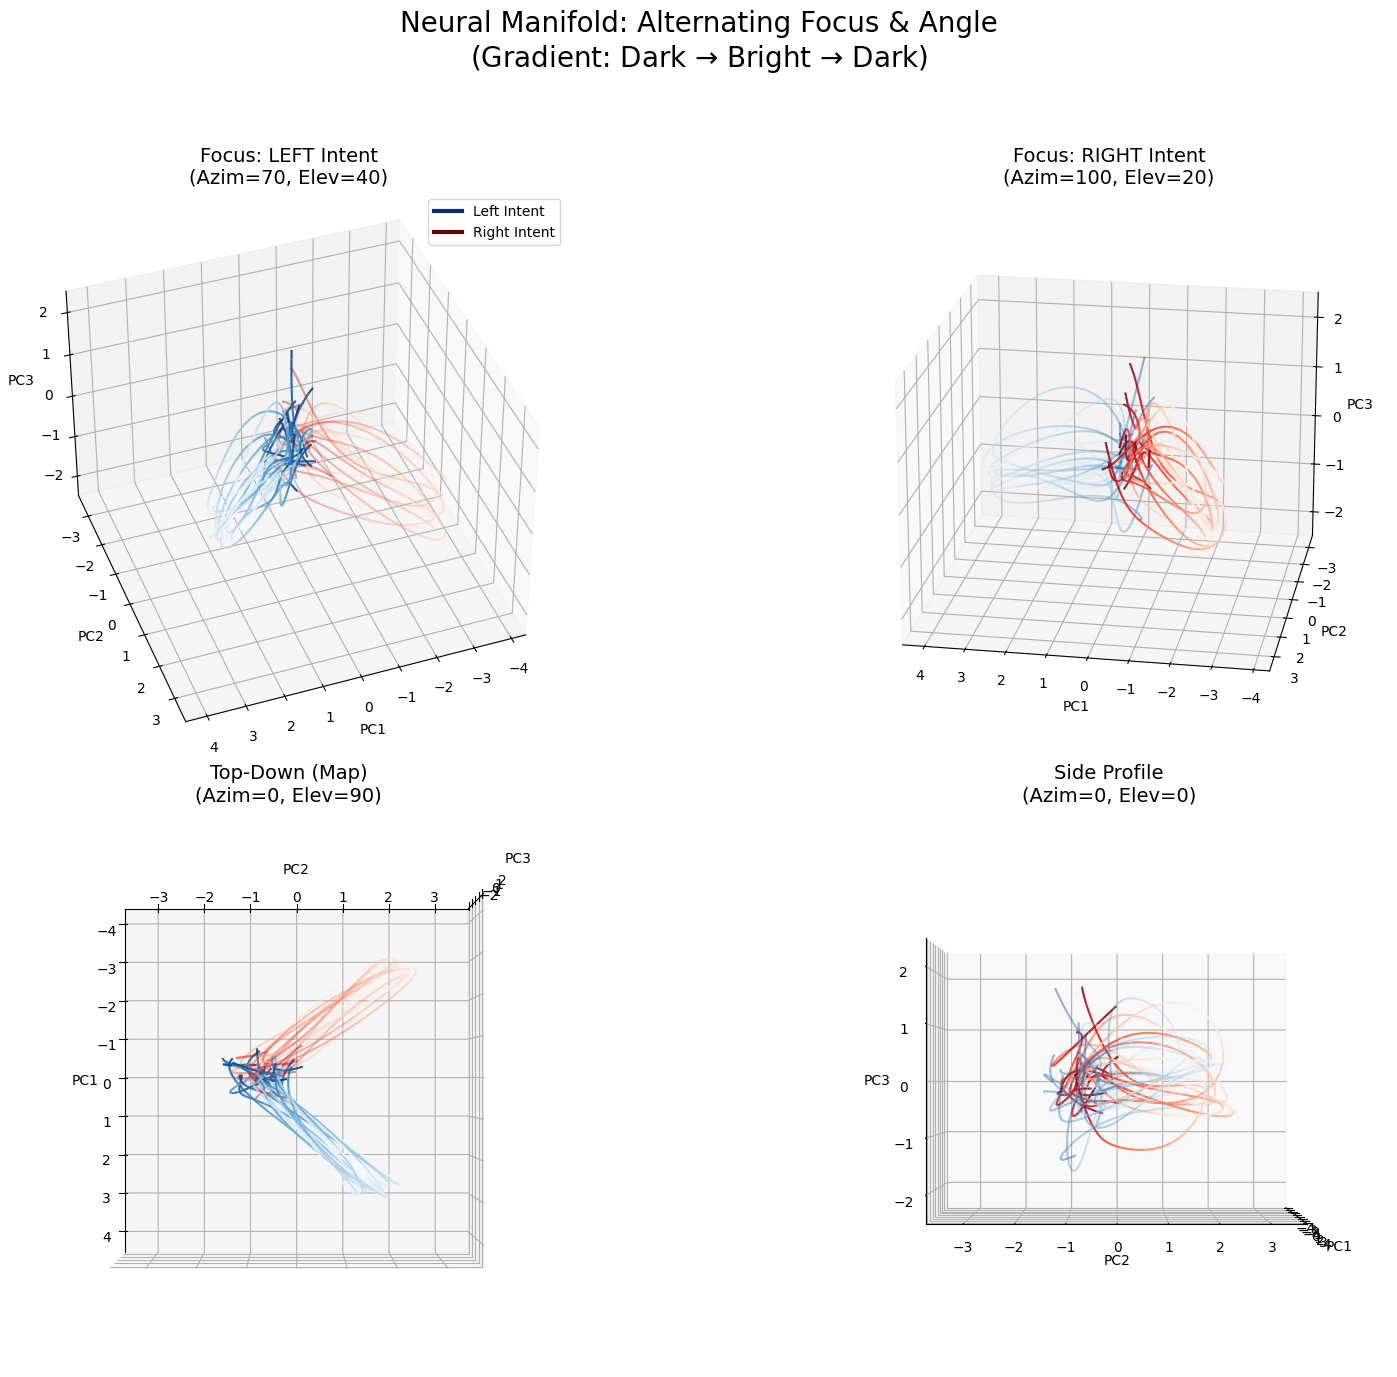

In [246]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.ndimage import gaussian_filter1d

# --- 1. PREPARE DATA ---
# Ensure we have the indices
left_idxs = np.where(y_labels == 'Left')[0]
right_idxs = np.where(y_labels == 'Right')[0]
sigma_smooth = 4.5

# --- 2. DEFINE PLOTTING FUNCTION ---
def plot_symmetric_gradient(ax, x, y, z, cmap, base_alpha=0.9, lw=2):
    """
    Plots a 3D trajectory with a 'Dark -> Bright -> Dark' color gradient.
    """
    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    n_seg = len(segments)
    
    # LINEAR TIME: 0.0 to 1.0
    t = np.linspace(0.0, 1.0, n_seg)
    
    # TRIANGLE WAVE FOR BRIGHTNESS: 0.0 -> 1.0 -> 0.0
    # This creates the "Dark -> Bright -> Dark" effect if using a Dark->Light colormap
    color_indices = 1.0 - 2.0 * np.abs(t - 0.5)
    
    # MAP COLORS
    colors = cmap(color_indices)
    
    # SET ALPHA
    # We apply the requested base_alpha uniformly to maintain the "Focus" effect
    colors[:, 3] = base_alpha 

    # Create collection
    lc = Line3DCollection(segments, colors=colors, linewidths=lw)
    ax.add_collection(lc)

# --- 3. SETUP FIGURE ---
fig = plt.figure(figsize=(18, 14))
fig.suptitle(f"Neural Manifold: Alternating Focus & Angle\n(Gradient: Dark $\u2192$ Bright $\u2192$ Dark)", fontsize=20)

# Configurations for the 4 plots
# (Elevation, Azimuth, Left_Alpha, Right_Alpha, Title_Suffix)
configs = [
    (40, 70,  0.9, 0.4, "Focus: LEFT Intent"),    # Standard view, Left Opaque
    (20, 100,  0.4, 0.9, "Focus: RIGHT Intent"),   # Reverse view, Right Opaque
    (90, 0,    0.9, 0.4, "Top-Down (Map)"),        # Top view, Left Opaque
    (0, 0,     0.4, 0.9, "Side Profile")           # Side view, Right Opaque
]

# Get data limits for consistent scaling
all_data = X_pca_3d.reshape(-1, 3)
xlims = (all_data[:,0].min(), all_data[:,0].max())
ylims = (all_data[:,1].min(), all_data[:,1].max())
#zlims = (all_data[:,2].min(), all_data[:,2].max())
zlims = (-2.5, 2.5)

# --- 4. PLOTTING LOOP ---
for i, (elev, azim, alpha_L, alpha_R, title) in enumerate(configs):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    
    # Plot LEFT Trials (Blue Theme)
    # Blues_r: 0.0 is Dark Blue, 1.0 is White. 
    # Our triangle wave goes 0 -> 1 -> 0, so Dark -> Bright -> Dark.
    for idx in left_idxs:
        traj = gaussian_filter1d(X_pca_3d[idx, :, :], sigma=sigma_smooth, axis=0)
        plot_symmetric_gradient(ax, traj[:,0], traj[:,1], traj[:,2], 
                                cmap=plt.cm.Blues_r, base_alpha=alpha_L, lw=1.5)

    # Plot RIGHT Trials (Red Theme)
    # Reds_r: 0.0 is Dark Red, 1.0 is White.
    for idx in right_idxs:
        traj = gaussian_filter1d(X_pca_3d[idx, :, :], sigma=sigma_smooth, axis=0)
        plot_symmetric_gradient(ax, traj[:,0], traj[:,1], traj[:,2], 
                                cmap=plt.cm.Reds_r, base_alpha=alpha_R, lw=1.5)

    # Set View and Labels
    ax.view_init(elev=elev, azim=azim)
    ax.set_title(f"{title}\n(Azim={azim}, Elev={elev})", fontsize=14)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    # Enforce constant limits so plots are comparable
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_zlim(zlims)
    
    # Legend Proxy Lines (Colored to match the "Dark" start/end of the gradient)
    if i == 0: # Only add legend to first plot to save space
        ax.plot([], [], [], color=plt.cm.Blues_r(0.0), lw=3, label='Left Intent')
        ax.plot([], [], [], color=plt.cm.Reds_r(0.0), lw=3, label='Right Intent')
        ax.legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [240]:
import numpy as np
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter1d
import os

# --- 1. SETUP & PARAMETERS ---
# Define smoothing (higher = smoother lines)
sigma_smooth = 4.5 

# Ensure output directory exists
save_dir = '../data/03_results'
os.makedirs(save_dir, exist_ok=True)

# Identify indices for Left vs Right conditions
left_idxs = np.where(y_labels == 'Left')[0]
right_idxs = np.where(y_labels == 'Right')[0]

# Initialize the Plotly Figure
fig = go.Figure()

# --- 2. HELPER FUNCTION TO ADD LINES ---
def add_plotly_lines(indices, color_name, group_name):
    """
    Adds smoothed trajectories to the Plotly figure.
    - indices: List of trial indices to plot
    - color_name: 'blue' or 'red' (CSS color names)
    - group_name: Label for the legend (e.g., 'Left Intent')
    """
    print(f"Adding {group_name} traces...")
    
    for i, idx in enumerate(indices):
        # Apply Gaussian Smoothing to the 3D trajectory
        traj = gaussian_filter1d(X_pca_3d[idx, :, :], sigma=sigma_smooth, axis=0)
        
        # We only show the legend for the first line of the group
        # so the legend isn't cluttered with 100 entries
        show_legend = True if i == 0 else False
        
        fig.add_trace(go.Scatter3d(
            x=traj[:, 0], 
            y=traj[:, 1], 
            z=traj[:, 2],
            mode='lines',
            line=dict(
                color=color_name, 
                width=4  # Thicker lines are easier to grab/see
            ),
            opacity=0.4, # Low opacity creates the "Cloud" effect
            name=group_name,
            legendgroup=group_name, # Groups them so clicking one legend item toggles all
            showlegend=show_legend
        ))

# --- 3. ADD DATA TO FIGURE ---
# Add Left Trials (Blue Cloud)
add_plotly_lines(left_idxs, 'deepskyblue', 'Left Intent')

# Add Right Trials (Red Cloud)
add_plotly_lines(right_idxs, 'crimson', 'Right Intent')



# --- 5. FINALIZE LAYOUT & SAVE ---
fig.update_layout(
    title="Interactive Neural Manifold (Drag to Rotate)",
    scene=dict(
        xaxis_title='PC1 (Laterization)',
        yaxis_title='PC2 (State)',
        zaxis_title='PC3 (Dynamics)',
        aspectmode='cube' # Keeps axes proportional
    ),
    width=1000,
    height=800,
    margin=dict(l=0, r=0, b=0, t=50) # Tight layout
)

# Save to HTML file
output_path = f"{save_dir}/interactive_manifold.html"
fig.write_html(output_path)

print(f"✅ Success! Interactive plot saved to: {output_path}")
print("Go to your data folder and open this file in Chrome/Firefox/Safari to explore the manifold.")

Adding Left Intent traces...
Adding Right Intent traces...
✅ Success! Interactive plot saved to: ../data/03_results/interactive_manifold.html
Go to your data folder and open this file in Chrome/Firefox/Safari to explore the manifold.
